In [1]:
import os
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.optimizers import AdamW
import keras.utils as image
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

2024-05-01 01:14:23.839846: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 01:14:23.965643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 01:14:23.965692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 01:14:23.967813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 01:14:24.002336: I tensorflow/core/platform/cpu_feature_guar

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
train_dir = '/home/btech/2021/abhishek.kumar21b/malware_detection/malimg_dataset/train'
test_dir = '/home/btech/2021/abhishek.kumar21b/malware_detection/malimg_dataset/test'
val_dir = '/home/btech/2021/abhishek.kumar21b/malware_detection/malimg_dataset/val'

# Image size


In [3]:
image_size = (224, 224, 3)
batch_size=32

In [4]:

# Load images
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)


In [5]:
# Load training and test images
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)
val_images, val_labels = load_images(val_dir)


# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0

In [6]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
train_datagen.fit(train_images)


In [7]:
train_images.shape

(7459, 224, 224, 3)

In [8]:
print(train_labels)

[ 0  0  0 ... 24 24 24]


In [9]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=image_size)
for layer in base_model.layers[:-5]:  # Fine-tune top 5 layers
    layer.trainable = False

2024-05-01 01:20:53.549271: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-01 01:20:53.549360: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: AI-iiitg
2024-05-01 01:20:53.549372: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: AI-iiitg
2024-05-01 01:20:53.549615: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 545.23.8
2024-05-01 01:20:53.549655: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 545.23.8
2024-05-01 01:20:53.549663: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 545.23.8


In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.5)(x)
predictions = Dense(25, activation='softmax')(x)

In [11]:
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with AdamW optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer=AdamW(learning_rate=1e-4), metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [12]:
history = model.fit(
    train_datagen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=50,  # Adjust as needed
    validation_data=(val_images, val_labels),  # If using a validation set
    callbacks=[early_stopping]
)


Epoch 1/50
234/234 [==============================] - 344s 1s/step - loss: 10.0004 - accuracy: 0.7623 - val_loss: 8.7325 - val_accuracy: 0.7064
Epoch 2/50
234/234 [==============================] - 316s 1s/step - loss: 7.2710 - accuracy: 0.9000 - val_loss: 6.3018 - val_accuracy: 0.9057
Epoch 3/50
234/234 [==============================] - 320s 1s/step - loss: 5.4858 - accuracy: 0.9229 - val_loss: 4.8626 - val_accuracy: 0.8884
Epoch 4/50
234/234 [==============================] - 333s 1s/step - loss: 4.1204 - accuracy: 0.9332 - val_loss: 3.6104 - val_accuracy: 0.9144
Epoch 5/50
234/234 [==============================] - 347s 1s/step - loss: 3.1057 - accuracy: 0.9410 - val_loss: 2.8434 - val_accuracy: 0.9003
Epoch 6/50
234/234 [==============================] - 317s 1s/step - loss: 2.3362 - accuracy: 0.9469 - val_loss: 2.0848 - val_accuracy: 0.9328
Epoch 7/50
234/234 [==============================] - 331s 1s/step - loss: 1.7583 - accuracy: 0.9520 - val_loss: 1.5793 - val_accuracy: 0.950

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [14]:
# Train the model (adjust epochs and batch size as needed)
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(val_images, val_labels))

Epoch 1/10
 24/234 [==>...........................] - ETA: 3:29 - loss: 0.2061 - accuracy: 0.9583

234/234 [==============================] - 269s 1s/step - loss: 0.1543 - accuracy: 0.9714 - val_loss: 0.1080 - val_accuracy: 0.9859
Epoch 2/10
234/234 [==============================] - 261s 1s/step - loss: 0.1042 - accuracy: 0.9866 - val_loss: 0.0863 - val_accuracy: 0.9859
Epoch 3/10
234/234 [==============================] - 260s 1s/step - loss: 0.0859 - accuracy: 0.9889 - val_loss: 0.0854 - val_accuracy: 0.9870
Epoch 4/10
234/234 [==============================] - 260s 1s/step - loss: 0.0752 - accuracy: 0.9902 - val_loss: 0.0696 - val_accuracy: 0.9870
Epoch 5/10
234/234 [==============================] - 260s 1s/step - loss: 0.0754 - accuracy: 0.9901 - val_loss: 0.0678 - val_accuracy: 0.9892
Epoch 6/10
234/234 [==============================] - 262s 1s/step - loss: 0.0614 - accuracy: 0.9940 - val_loss: 0.0637 - val_accuracy: 0.9881
Epoch 7/10
234/234 [==============================] - 260s 1s/step - loss: 0.0647 - accuracy: 0.9946 - val_loss: 0.0623 - val_accuracy: 0.9913
Epoch 8/10

In [15]:
# Extract features using MobileNetV1
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)

In [16]:
# Extract features using the model without the top layer in batches
# Get the penultimate layer's output
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)


batch_size=32
# Use the extract_features function to process images in batches
train_features = extract_features(feature_extractor, train_images, batch_size)
test_features = extract_features(feature_extractor, test_images, batch_size)

print("Shape of extracted train features:", train_features.shape)
print("Shape of extracted test features:", test_features.shape)

1/1 [==============================] - 1s 965ms/step


1/1 [==============================] - 1s 1s/step
Shape of extracted train features: (7459, 1024)
Shape of extracted test features: (957, 1024)


In [17]:
# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10]
}

# Create Random Forest classifier
rf_classifier = RandomForestClassifier()

# Use GridSearchCV to find the best parameters for Random Forest
rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(train_features, train_labels)

# Get the best parameters for Random Forest
best_rf_params = rf_grid_search.best_params_

# Train the final Random Forest model with the best parameters
final_rf_classifier = RandomForestClassifier(**best_rf_params)
start_time_rf = time.time()
final_rf_classifier.fit(train_features, train_labels)
train_time_rf = time.time() - start_time_rf

# Predict labels for the test set using Random Forest
rf_predictions = final_rf_classifier.predict(test_features)

# Evaluate accuracy for Random Forest
rf_accuracy = accuracy_score(test_labels, rf_predictions)
print("\nBest Random Forest Parameters:", best_rf_params)
print("Random Forest Accuracy:", rf_accuracy)



Best Random Forest Parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 500}
Random Forest Accuracy: 0.9895506792058516


In [18]:
# Additional evaluation metrics for Random Forest
precision_rf = precision_score(test_labels, rf_predictions, average='weighted')
recall_rf = recall_score(test_labels, rf_predictions, average='weighted')
f1_rf = f1_score(test_labels, rf_predictions, average='weighted')

print("Train Time (sec) Random Forest:", train_time_rf)
grid_train_time_rf = rf_grid_search.cv_results_['mean_fit_time'][rf_grid_search.best_index_]
print("Train Time (sec) Grid Random Forest:", grid_train_time_rf)

# Calculate Matthews Correlation Coefficient (MCC) for Random Forest
mcc_rf = matthews_corrcoef(test_labels, rf_predictions)
print("Matthews Correlation Coefficient (MCC) Random Forest:", mcc_rf)


Train Time (sec) Random Forest: 296.33806848526
Train Time (sec) Grid Random Forest: 233.46249993642172
Matthews Correlation Coefficient (MCC) Random Forest: 0.9878481168542186


In [19]:

# Confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(test_labels, rf_predictions)
precision_rf = precision_score(test_labels, rf_predictions, average='weighted')

FP_rf = conf_matrix_rf.sum(axis=0) - np.diag(conf_matrix_rf)
FN_rf = conf_matrix_rf.sum(axis=1) - np.diag(conf_matrix_rf)
TP_rf = np.diag(conf_matrix_rf)
TN_rf = conf_matrix_rf.sum()


In [20]:
# Display results for Random Forest
print("\nResults for Random Forest:")
print("Precision (Random Forest):", precision_rf)
print("Recall (Random Forest):", recall_rf)
print("F1 Score (Random Forest):", f1_rf)
print("True Positive Rate (TPR) (Random Forest):", np.mean(TP_rf / (TP_rf + FN_rf)))
print("True Negative Rate (TNR) (Random Forest):", np.mean(TN_rf / (TN_rf + FP_rf)))
print("False Positive Rate (FPR) (Random Forest):", np.mean(FP_rf / (FP_rf + TN_rf)))
print("False Negative Rate (FNR) (Random Forest):", np.mean(FN_rf / (TP_rf + FN_rf)))
print("False Discovery Rate (FDR) (Random Forest):", np.mean(FP_rf / (FP_rf + TP_rf)))
print("False Omission Rate (FOR) (Random Forest):", np.mean(FN_rf / (FN_rf + TN_rf)))
print("Matthews Correlation Coefficient (MCC) (Random Forest):", mcc_rf)



Results for Random Forest:
Precision (Random Forest): 0.9904741442410108
Recall (Random Forest): 0.9895506792058516
F1 Score (Random Forest): 0.9896929564832244
True Positive Rate (TPR) (Random Forest): 0.9777005683770389
True Negative Rate (TNR) (Random Forest): 0.99958341860236
False Positive Rate (FPR) (Random Forest): 0.000416581397639868
False Negative Rate (FNR) (Random Forest): 0.02229943162296103
False Discovery Rate (FDR) (Random Forest): 0.024516908212560383
False Omission Rate (FOR) (Random Forest): 0.0004170151568803373
Matthews Correlation Coefficient (MCC) (Random Forest): 0.9878481168542186


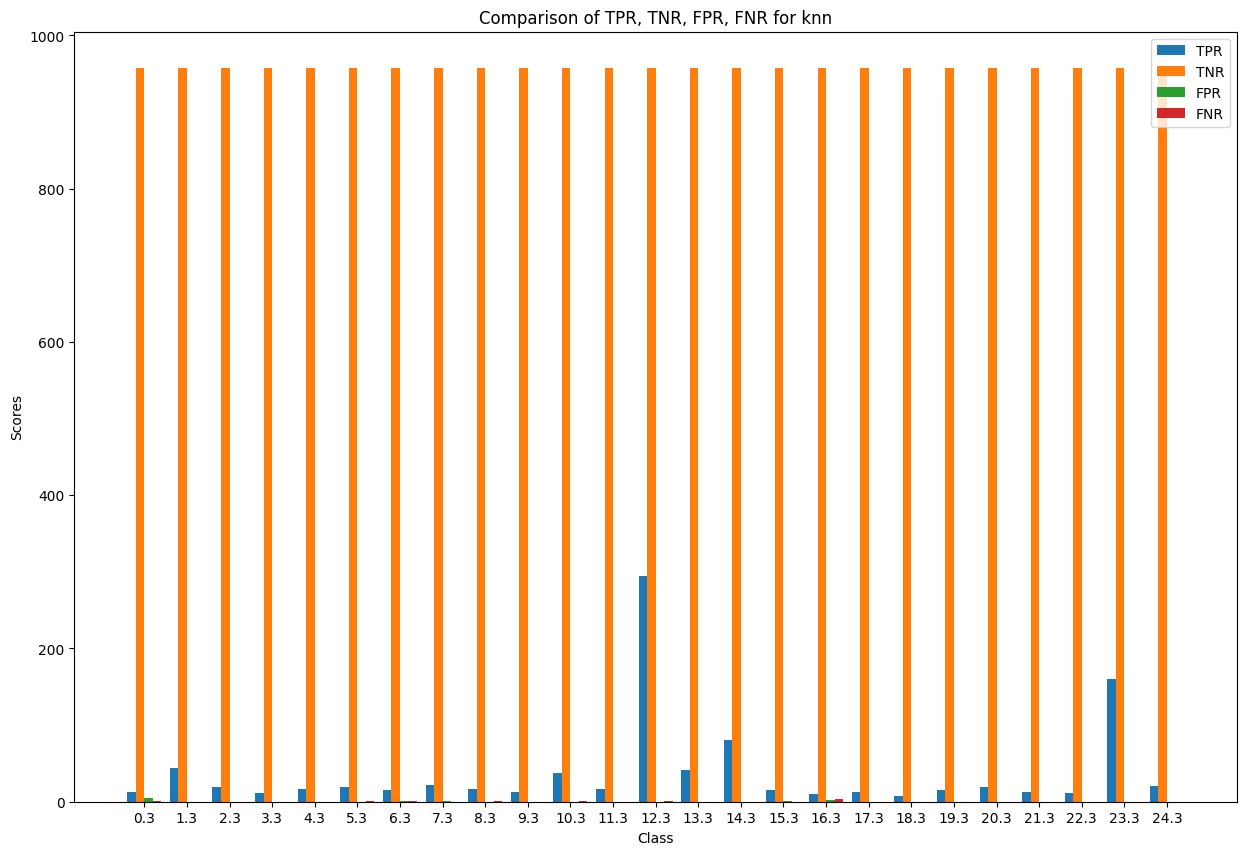

In [21]:
# Plot TPR, TNR, FPR, FNR
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data

bar1 = ax.bar(index, TP_rf, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN_rf, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP_rf, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN_rf, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for knn')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

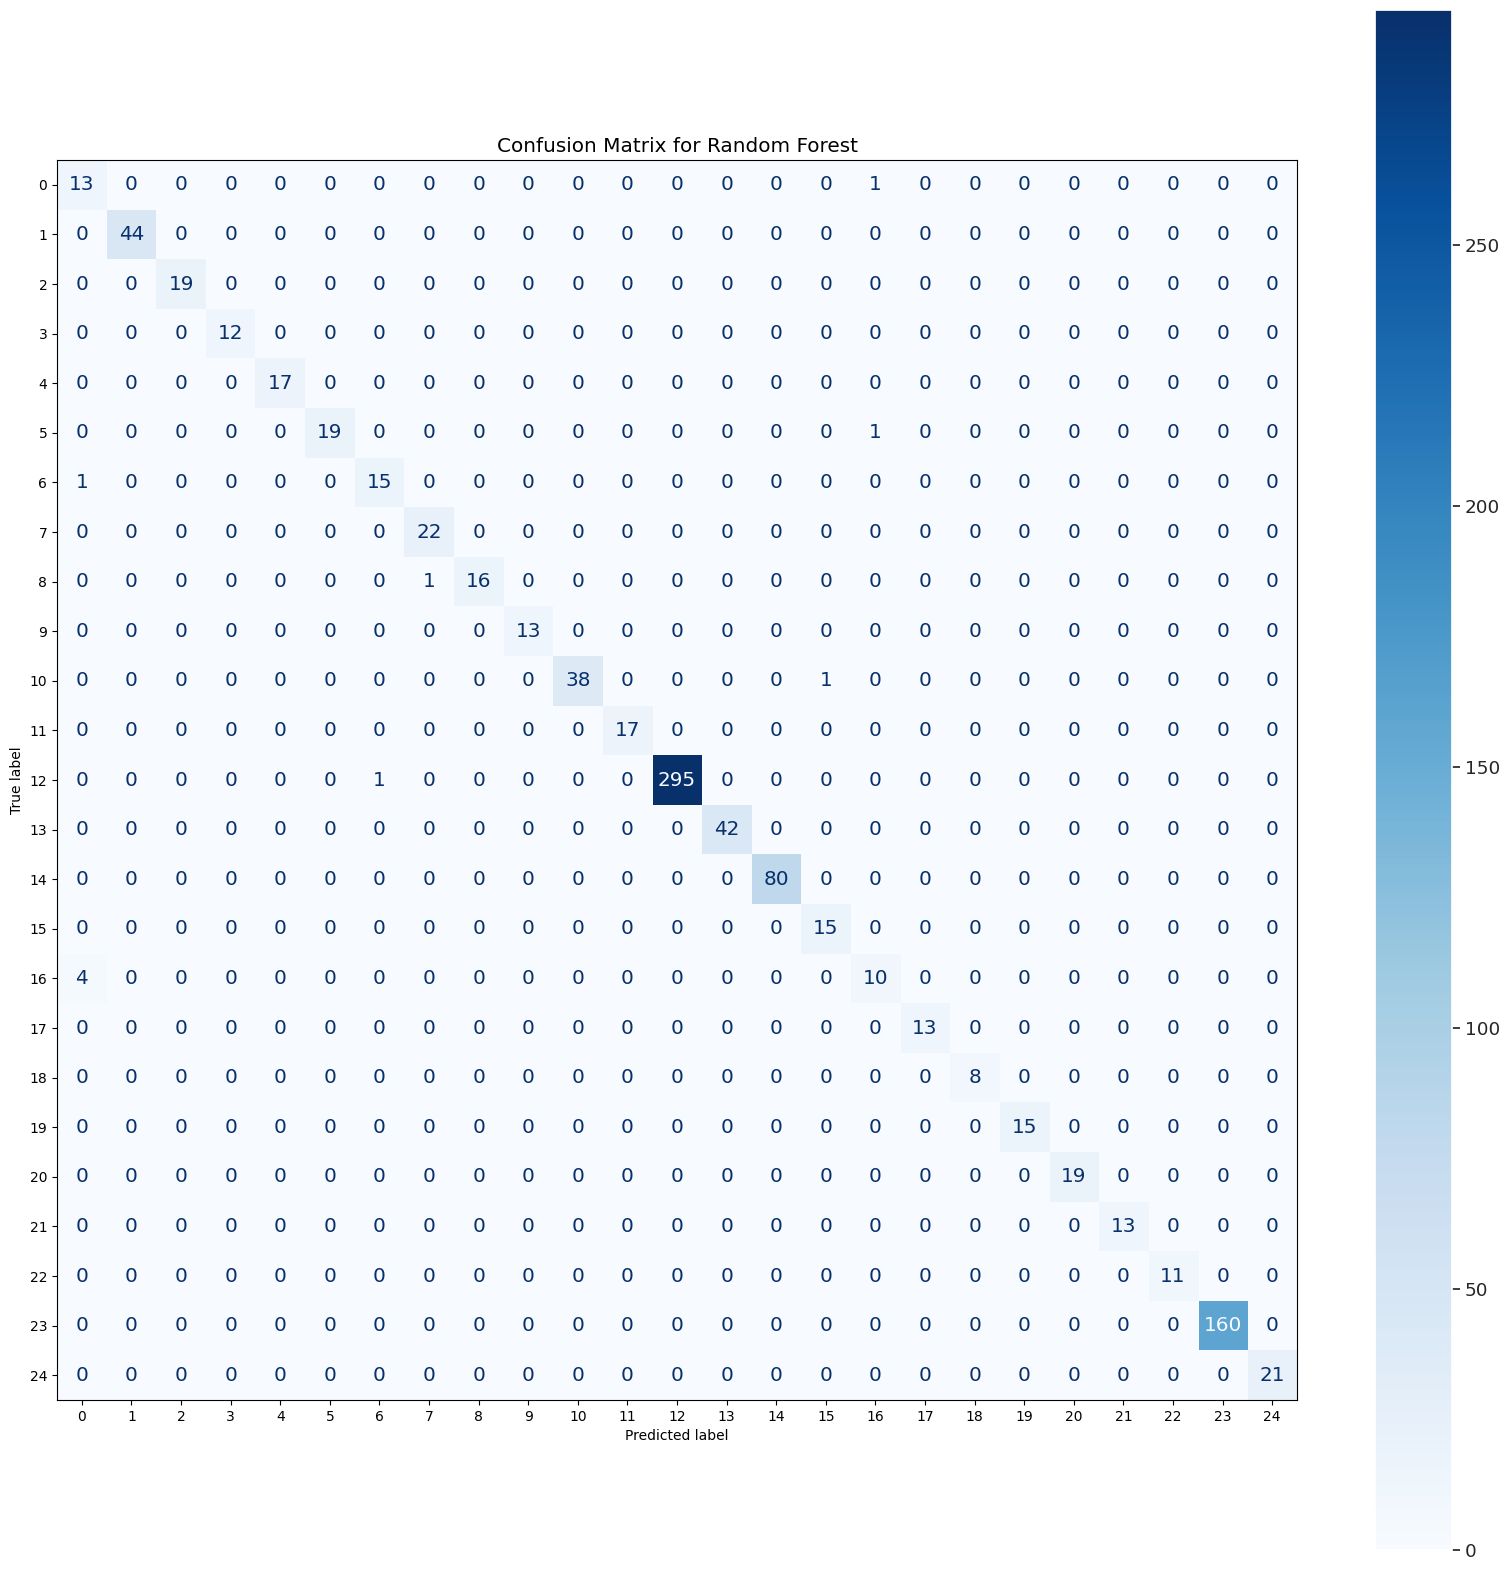

In [22]:
# Plot Confusion Matrix for Random Forest
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix_rf, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for Random Forest')
plt.show()